# Liver Model Construction: Notebook

In [1]:
import os
import re
import warnings
from cobra.io import *
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa, qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
import sys
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")


### Getting reactions and metabolite data from RECON 3D

In [4]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"core_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')



# making dataframe of reactions
csv_rxn = os.path.join(data_dir,"core_reaction_df.csv")
rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [5]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-04-30


In [6]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [7]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"core_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [8]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [9]:
# #adding DM_NADH 
# nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
# rxn = cobra.Reaction('DM_nadh')
# trial.add_reaction(rxn)
# rxn.add_metabolites(nadhm)




peptm = {'pep_m': -1, 'pi_c': -1, 'pi_m': 1, 'pep_c':1}
rxn2 = cobra.Reaction('PEPtm')
rxn2.lower_bound=0
trial.add_reaction(rxn2)
rxn2.add_metabolites(peptm)



# g6pase = {'g6p_c': -1, 'h2o_c': -1, 'pi_c': 1, 'glc__D_c':1}
# rxn3 = cobra.Reaction('G6PP')
# trial.add_reaction(rxn3)
# rxn3.add_metabolites(g6pase)

htm = {'h_c': -1,  'h_m': 1}
rxn4 = cobra.Reaction('Htm')
trial.add_reaction(rxn4)
rxn4.add_metabolites(htm)

pitm = {'h_i': -1,'pi_c': -1,  'h_m': 1,  'pi_m': 1}
rxn5 = cobra.Reaction('PItm')
trial.add_reaction(rxn5)
rxn5.lower_bound=0
rxn5.add_metabolites(pitm)
# # 
# # nadph_c --> h_c + nadp_c
nadphm = {'nadph_c': -1, 'h_c': 1,  'nadp_c': 1}
rxn6 = cobra.Reaction('NADPHM')
trial.add_reaction(rxn6)
rxn6.lower_bound=0
rxn6.add_metabolites(nadphm)


In [10]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

NADH2_u10mi {'charge': 1.0}
FADH2ETC {}
CYOR_u10mi {'charge': -2.0}
CYOOm2i {'charge': 4.0}
ATPS4mi {'charge': -1.0}
Htmi {}
CSm {'charge': -1.0}
ACONTm {}
ICDHxm {}
AKGDm {}
SUCOASm {'charge': 2.0}
SUCD1m {}
FUMm {}
MDHm {'charge': -1.0}
PDHm {}
PCm {'charge': 1.0}
PEPCKm {}
FBP {'charge': 2.0}
MALtm {}
MDH {'charge': -1.0}
PEPCK_re {}
HCO3Em {'charge': -1.0}
ATPtm {}
AKGMALtm {}
ASPTA {}
ASPTAm {}
PYRt2m {}
ASPGLUm {}
O2tm {}
H2Otm {}
CO2tm {}
NDPK1m {}
NDPK1 {}
ATPM {'charge': 1.0}
HEX1 {'charge': -1.0}
PGI {}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
G6PDH2r {'charge': -1.0}
PGL {'charge': -1.0}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
SPODM {'charge': 2.0}
GTHPi {}
GTHOr {'charge': 1.0}
PEPtm {}
Htm {}
PItm {}
NADPHM {'charge': 1}


In [11]:
for met in ['glc__D_c',
#  'pyr_c', 
'h2o_c', 'h_c', 'pi_c','lac__L_c','co2_c','o2_c','o2s_c','r5p_c']:
    # DOUBLE CHECK PYRUVATE EXCHANGE
    rxn = cobra.Reaction('EX_%s' % met)
    
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'r5p_c' or met == 'lac__L_c' or met == 'lac__L_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [12]:
len(trial.reactions)

69

In [13]:
trial.metabolites.h_c.charge= 1
trial.metabolites.h_m.charge= 1
trial.metabolites.h_i.charge= 1
trial.metabolites.pi_c.charge= -2
trial.metabolites.pi_m.charge= -2

In [14]:
trial.objective = 'ATPS4mi'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
NADH2_u10mi,10.000000,-2.220446e-16
FADH2ETC,2.000000,0.000000e+00
CYOR_u10mi,12.000000,0.000000e+00
CYOOm2i,6.000000,0.000000e+00
ATPS4mi,25.384615,-5.551115e-17
...,...,...
EX_lac__L_c,0.000000,-2.538462e+01
EX_co2_c,6.000000,0.000000e+00
EX_o2_c,-6.000000,-0.000000e+00
EX_o2s_c,0.000000,-0.000000e+00


In [17]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)
escher_builder

Builder(highlight_missing=True)

In [15]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'NADH2_u10mi': 10.0, 'FADH2ETC': 2.0, 'CYOR_u10mi': 12.0, 'CYOOm2i': 6.0, 'ATPS4mi': 25…

In [16]:
from cobra.io.json import load_json_model as load_json_cobra_model
from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob
# import cplex as cplex
# import gurobipy as gurobi

In [17]:
# glycolysis_ppp_tca_etc= load_json_cobra_model(filename=os.path.join(model_dir,"glycolysis_ppp_tca_etc_model.json"))
# R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [18]:
core_json = os.path.join(model_dir,"gly_ppp_tca.json")
json.save_json_model(model=trial, filename=core_json)

In [19]:
for model_file in glob(core_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    #removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    ### normalise each column by the min  qty in the column
    csv_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv_2.csv")
    df.to_csv(csv_dir)

c:\Users\sicil\LiverModel\models\gly_ppp_tca.json
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp8nkpd9jh.lp
Reading time = 0.01 seconds
: 74 rows, 136 columns, 512 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpyxcj2f45.lp
Reading time = 0.02 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpw8mvl_ol.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpecq0guz5.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpm6xvybtk.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpuz7u0bv0.lp
Reading time = 0.02 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpyfvvu6u

In [20]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv.csv")

In [21]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv.csv")
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,3,4,5,6,7,8,9,Norm0,Norm1,Norm2,Norm3,Norm4,Norm5,Norm6,Norm7,Norm8,Norm9
NADH2_u10mi,0.090909,0.0,0.086614,0.088889,0.000000,0.00,0.000000,0.0,0.333333,0.379562,5.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,4.0,4.000000
FADH2ETC,0.018182,0.0,0.023622,0.022222,0.000000,0.00,0.000000,0.0,0.083333,0.094891,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000
CYOR_u10mi,0.109091,0.0,0.110236,0.111111,0.000000,0.00,0.000000,0.0,0.416667,0.474453,6.0,0.0,14.0,5.0,0.0,0.0,0.0,0.0,5.0,5.000000
CYOOm2i,0.054545,0.0,0.055118,0.055556,0.000000,0.00,0.000000,0.0,0.208333,0.237226,3.0,0.0,7.0,2.5,0.0,0.0,0.0,0.0,2.5,2.500000
ATPS4mi,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.750000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_lac__L_c,-0.018182,1.0,-0.023622,-0.022222,0.666667,0.00,0.666667,0.0,-0.083333,-0.094891,-1.0,2.0,-3.0,-1.0,2.0,0.0,2.0,0.0,-1.0,-1.000000
EX_co2_c,0.054545,0.0,0.070866,0.066667,0.000000,0.25,0.000000,0.0,0.250000,0.284672,3.0,0.0,9.0,3.0,0.0,5.0,0.0,0.0,3.0,3.000000
EX_o2_c,-0.054545,0.0,-0.055118,-0.055556,0.000000,0.50,0.000000,0.0,-0.208333,-0.237226,-3.0,0.0,-7.0,-2.5,0.0,10.0,0.0,0.0,-2.5,-2.500000
EX_o2s_c,0.000000,0.0,0.000000,0.000000,0.000000,-1.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,0.0,0.0,0.000000


In [22]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,19].iteritems()}

In [23]:
import escher
from escher import Builder

In [24]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'NADH2_u10mi': 4.0, 'FADH2ETC': 1.0, 'CYOR_u10mi': 5.0, 'CYOOm2i': 2.5, 'ATPS4mi': 10.5…

In [25]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [26]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)

met_df=met_df.set_index('id')

In [27]:
csv_met_cobra = os.path.join(data_dir,"core_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [28]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)

rxn_df=rxn_df.set_index('id')

In [29]:
json_rxn_cobra = os.path.join(data_dir,"core_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index")

## Making MASS model of glycolysis

In [30]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [31]:
import json

In [32]:
# making dataframe of metabolites

met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"glycolysis_gluconeogenesis_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

In [33]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [34]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

## Setting initial conditions

In [35]:
import csv
import openpyxl

In [36]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [37]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

In [38]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)

In [39]:
conc_df.loc['udp_c','Concentration (M)']

0.00031588815999999997

In [40]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            # print(mid)
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            print(mid,ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            met.ic =  int(ic_value)            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
nad_m 8.33773e-06
nadh_m 0.000288577105
adp_m 0.008038905800000001
atp_m 0.00919
pi_m 0.00045
accoa_m 0.001373201
cit_m 0.0060226752
coa_m 0.0015432010000000001
oaa_m 3.119e-05
cit_m 0.0060226752
icit_m 4.2000000000000004e-05
akg_m 0.001605
icit_m 4.2000000000000004e-05
nad_m 8.33773e-06
nadh_m 0.000288577105
akg_m 0.001605
coa_m 0.0015432010000000001
nad_m 8.33773e-06
nadh_m 0.000288577105
succoa_m 0.00013000000000000002
adp_m 0.008038905800000001
atp_m 0.00919
coa_m 0.0015432010000000001
pi_m 0.00045
succ_m 0.000633435475
succoa_m 0.00013000000000000002
fum_m 0.0084280308
succ_m 0.000633435475
fum_m 0.0084280308
mal__L_m 0.002703530905
mal__L_m 0.002703530905
nad_m 8.33773e-06
nadh_m 0.000288577105
oaa_m 3.119e-05
accoa_m 0.001373201
coa_m 0.0015432010000000001
nad_m 8.33773e-06
nadh_m 0.000288577105
pyr_m 0.00134
adp_m 0.008038905800000001
atp_m 0.00919
oaa_m 3.119e-05
pi_m 0.00045
pyr_m 0.00134
oaa_m 3.119e-05
pep_m 0.0020499999999999997
f6p_c 

In [41]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x01f5ba269df0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


### Getting Standard and Physiological Gibbs energies of reactions

In [42]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", 
# "NADHM",
#transport reactions
'NADPHM', "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm',
# these two reactions below cause issues in equilibrator
'CYOR_u10mi' , 'CYOOm2i']

for reaction in excluded_reactions:
    rxn=liver.reactions.get_by_id(reaction)
    rxn.Keq=1    # Setting Keq
    rxn.kf=1e6     # Setting kf

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADPHM.Keq=1e6

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_r5p_c: r5p_c <=> 
r5p_b: 7.72171e-06



In [43]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp 

In [44]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")    

NADH2_u10mi
Keq = 1.1097827514444105e+22
FADH2ETC
Keq = 5.023025404471424e+19
ATPS4mi
Keq = 5.976530315538269e-09
CSm
Keq = 3825036.234120267
ACONTm
Keq = 0.08298137980719675
ICDHxm
Keq = 132.56877597611685
AKGDm
Keq = 42244.831063136786
SUCOASm
Keq = 1.4643104514453096
SUCD1m
Keq = 4.997902379212323e-08
FUMm
Keq = 3.772878492916711
MDHm
Keq = 4.7812151480308246e-05
PDHm
Keq = 557041.79687703
PCm
Keq = 26.659254851731617
PEPCKm
Keq = 5.8718785452391975
FBP
Keq = 115004.76795942851
MDH
Keq = 4.7812151480308246e-05
PEPCK_re
Keq = 5.8718785452391975
HCO3Em
Keq = 33.18076124208141
ASPTA
Keq = 0.33333387781666934
ASPTAm
Keq = 0.33333387781666934
ASPGLUm
Keq = 1.0
NDPK1m
Keq = 3.117459754364046
NDPK1
Keq = 3.117459754364046
HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
K

In [45]:
liver.reactions.CYOR_u10mi

Reaction identifier,CYOR_u10mi
Name,CYOR u10mi
Memory address,0x01f5ba223d90
Subsystem,
Kinetic Reversibility,True
Stoichiometry,2.0 ficytC_m + 2.0 h_m + q10h2_m <=> 2.0 focytC_m + 4.0 h_i + q10_m 2.0 Ferricytochrome c + 2.0 H+ + Ubiquinol-10 <=> 2.0 Ferrocytochrome C + 4.0 H+ + Ubiquinone-10
GPR,
Bounds,"(0.0, 1000.0)"


In [46]:
# # these two reactions below cause issues in equilibrator
# weird_reactions = ['CYOR_u10mi' , 'CYOOm2i']
# for reaction in liver.reactions:
#     if reaction.id == 'CYOR_u10mi':
#         reaction_to_parse =  ("2 bigg.metabolite:h + 2 kegg:C00125 + chebi:CHEBI:64183 = 2 kegg:C00126 + kegg:C11378 + 4 bigg.metabolite:h")
      

#         rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
#         print(reaction.id)

#         #Getting Gibbs energies
#         dG0_prime = cc.standard_dg_prime(rxn_parsed)
#         print(f"ΔG'° = {dG0_prime}")
#         dGm_prime = cc.physiological_dg_prime(rxn_parsed)
#         dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
#         dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
#     #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
#         delG = dG_prime_value_in_kj_per_mol

#         # Calculating Keq from delG
#         a = exp(-delG/ (R*310.15)) 
#         reaction.Keq = a
#         print(f"Keq = {a}")
# #         list_keq=[reaction,a]
# #         rxn_keq=pd.DataFrame(list_keq)

        

In [47]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_NADH2_u10mi: 1.1097827514444105e+22
Keq_FADH2ETC: 5.023025404471424e+19
Keq_CYOR_u10mi: 1
Keq_CYOOm2i: 1
Keq_ATPS4mi: 5.976530315538269e-09
Keq_Htmi: 1
Keq_CSm: 3825036.234120267
Keq_ACONTm: 0.08298137980719675
Keq_ICDHxm: 132.56877597611685
Keq_AKGDm: 42244.831063136786
Keq_SUCOASm: 1.4643104514453096
Keq_SUCD1m: 4.997902379212323e-08
Keq_FUMm: 3.772878492916711
Keq_MDHm: 4.7812151480308246e-05
Keq_PDHm: 557041.79687703
Keq_PCm: 26.659254851731617
Keq_PEPCKm: 5.8718785452391975
Keq_FBP: 115004.76795942851
Keq_MALtm: 1
Keq_MDH: 4.7812151480308246e-05
Keq_PEPCK_re: 5.8718785452391975
Keq_HCO3Em: 33.18076124208141
Keq_ATPtm: 1
Keq_AKGMALtm: 1
Keq_ASPTA: 0.33333387781666934
Keq_ASPTAm: 0.33333387781666934
Keq_PYRt2m: 1
Keq_ASPGLUm: 1.0
Keq_O2tm: 1
Keq_H2Otm: 1
Keq_CO2tm: 1
Keq_NDPK1m: 3.117459754364046
Keq_NDPK1: 3.117459754364046
Keq_ATPM: 1000000.0
Keq_HEX1: 4959.419292148073
Keq_PGI: 0.34798040939490554
Keq_PFK: 1454.9063091036724
Keq_FBA

##  Set Fluxes

In [48]:
liver.metabolites.o2s_c

MassMetabolite identifier,o2s_c
Name,Superoxide anion
Memory address,0x01f5ba223340
Formula,O2
Compartment,c
Initial Condition,None
In 2 reaction(s),"EX_o2s_c, SPODM"


In [49]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv.csv")
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,3,4,5,6,7,8,9,Norm0,Norm1,Norm2,Norm3,Norm4,Norm5,Norm6,Norm7,Norm8,Norm9
NADH2_u10mi,0.090909,0.0,0.086614,0.088889,0.000000,0.00,0.000000,0.0,0.333333,0.379562,5.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,4.0,4.000000
FADH2ETC,0.018182,0.0,0.023622,0.022222,0.000000,0.00,0.000000,0.0,0.083333,0.094891,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000
CYOR_u10mi,0.109091,0.0,0.110236,0.111111,0.000000,0.00,0.000000,0.0,0.416667,0.474453,6.0,0.0,14.0,5.0,0.0,0.0,0.0,0.0,5.0,5.000000
CYOOm2i,0.054545,0.0,0.055118,0.055556,0.000000,0.00,0.000000,0.0,0.208333,0.237226,3.0,0.0,7.0,2.5,0.0,0.0,0.0,0.0,2.5,2.500000
ATPS4mi,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.750000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_lac__L_c,-0.018182,1.0,-0.023622,-0.022222,0.666667,0.00,0.666667,0.0,-0.083333,-0.094891,-1.0,2.0,-3.0,-1.0,2.0,0.0,2.0,0.0,-1.0,-1.000000
EX_co2_c,0.054545,0.0,0.070866,0.066667,0.000000,0.25,0.000000,0.0,0.250000,0.284672,3.0,0.0,9.0,3.0,0.0,5.0,0.0,0.0,3.0,3.000000
EX_o2_c,-0.054545,0.0,-0.055118,-0.055556,0.000000,0.50,0.000000,0.0,-0.208333,-0.237226,-3.0,0.0,-7.0,-2.5,0.0,10.0,0.0,0.0,-2.5,-2.500000
EX_o2s_c,0.000000,0.0,0.000000,0.000000,0.000000,-1.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,0.0,0.0,0.000000


In [50]:
import escher
from escher import Builder

In [51]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,5].iteritems()}

In [52]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'NADH2_u10mi': 0.0, 'FADH2ETC': 0.0, 'CYOR_u10mi': 0.0, 'CYOOm2i': 0.0, 'ATPS4mi': 0.0,…

In [53]:
# independent_fluxes=[]
#     0: PDHM #lactate to pyruvate to TCA cycle
#     1: HEX1 # glycolysis
#     2: # TCA again but 2 different reactions than 0 (PEPCK_re/MDH/) 
#     3: #TCA and ETC
#     4: #glycolysis but with PFK/FBP loop
#     5: #PPP
#     6: #glycolysis with HEX1/G6PP loop
#     7: #second half of PPP with upper part of glycolysis
#     8: #TCA again with small differences (transfers maybe)
#     9: # TCA with mitochondrial bypass
 

In [54]:
# making dataframe of reactions

# csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
# minspan_df = pd.read_csv(csv_minspan_dir,index_col="rxn") 
# minspan_df

In [55]:
reaction_list=[]
for reaction in trial.reactions:
    r_id = reaction.id
    reaction_list.append(r_id)

In [56]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux
    # * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_NADH2_u10mi: 10.0
v_FADH2ETC: 2.0
v_CYOR_u10mi: 12.0
v_CYOOm2i: 6.0
v_ATPS4mi: 25.384615384615383
v_Htmi: 0.0
v_CSm: 2.0
v_ACONTm: 2.0
v_ICDHxm: 2.0
v_AKGDm: 2.0
v_SUCOASm: -2.0
v_SUCD1m: 2.0
v_FUMm: 2.0
v_MDHm: 4.0
v_PDHm: 2.0
v_PCm: 8.46153846153846
v_PEPCKm: 8.46153846153846
v_FBP: 20.923076923076923
v_MALtm: 0.0
v_MDH: -2.0
v_PEPCK_re: 0.0
v_HCO3Em: 8.46153846153846
v_ATPtm: 10.461538461538463
v_AKGMALtm: 2.0
v_ASPTA: 2.0
v_ASPTAm: -2.0
v_PYRt2m: 10.46153846153846
v_ASPGLUm: 2.0
v_O2tm: 6.0
v_H2Otm: -24.923076923076927
v_CO2tm: -6.0
v_NDPK1m: 8.46153846153846
v_NDPK1: 0.0
v_ATPM: 0.0
v_HEX1: 1.0
v_PGI: 1.0
v_PFK: 21.923076923076923
v_FBA: 1.0
v_TPI: 1.0
v_GAPD: 2.0
v_PGK: -2.0
v_PGM: -2.0
v_ENO: 2.0
v_PYK: 10.46153846153846
v_LDH_L: 0.0
v_G6PDH2r: 0.0
v_PGL: 0.0
v_GND: 0.0
v_RPI: 0.0
v_RPE: 0.0
v_TKT1: 0.0
v_TKT2: 0.0
v_TALA: 0.0
v_SPODM: 0.0
v_GTHPi: 0.0
v_GTHOr: 0.0
v_PEPtm: 8.46153846153846
v_Htm: 0.0
v_PItm: 10.461538461538463
v_NADPHM: 0.0
v_EX_glc__D_c: -1.0
v_EX_h2o_c: 6.0

In [57]:
liver.metabolites.h_c.charge= 1
liver.metabolites.h_i.charge= 1
liver.metabolites.h_m.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2
liver.metabolites.pi_m.charge= -2

## Set H2O/H Constants

In [58]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",'h_i', 'h_m', 
    
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",'h2o_m', 
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c', 'pi_m'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [59]:
for metabolite in [
#     'h_m',
'h_i', 'h_m',
"h_c", 
   'o2_m', 'o2_c', 
#     'h_e',
"h2o_c",'h2o_m'
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [60]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            # print(mid)
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            print(mid,ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
nad_m 8.33773e-06
nadh_m 0.000288577105
adp_m 0.008038905800000001
atp_m 0.00919
pi_m 0.00045
accoa_m 0.001373201
cit_m 0.0060226752
coa_m 0.0015432010000000001
oaa_m 3.119e-05
cit_m 0.0060226752
icit_m 4.2000000000000004e-05
akg_m 0.001605
icit_m 4.2000000000000004e-05
nad_m 8.33773e-06
nadh_m 0.000288577105
akg_m 0.001605
coa_m 0.0015432010000000001
nad_m 8.33773e-06
nadh_m 0.000288577105
succoa_m 0.00013000000000000002
adp_m 0.008038905800000001
atp_m 0.00919
coa_m 0.0015432010000000001
pi_m 0.00045
succ_m 0.000633435475
succoa_m 0.00013000000000000002
fum_m 0.0084280308
succ_m 0.000633435475
fum_m 0.0084280308
mal__L_m 0.002703530905
mal__L_m 0.002703530905
nad_m 8.33773e-06
nadh_m 0.000288577105
oaa_m 3.119e-05
accoa_m 0.001373201
coa_m 0.0015432010000000001
nad_m 8.33773e-06
nadh_m 0.000288577105
pyr_m 0.00134
adp_m 0.008038905800000001
atp_m 0.00919
oaa_m 3.119e-05
pi_m 0.00045
pyr_m 0.00134
oaa_m 3.119e-05
pep_m 0.0020499999999999997
f6p_c 

In [61]:
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

h_i: 1
h_m: 1
nad_m: 8.33773e-06
nadh_m: 0.000288577105
h2o_m: 1
o2_m: 1
adp_m: 0.008038905800000001
atp_m: 0.00919
pi_m: 0.00045
accoa_m: 0.001373201
cit_m: 0.0060226752
coa_m: 0.0015432010000000001
oaa_m: 3.119e-05
icit_m: 4.2000000000000004e-05
akg_m: 0.001605
succoa_m: 0.00013000000000000002
succ_m: 0.000633435475
fum_m: 0.0084280308
mal__L_m: 0.002703530905
pyr_m: 0.00134
pep_m: 0.0020499999999999997
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
mal__L_c: 0.001522
h_c: 1
nad_c: 0.00182530972
nadh_c: 4.63542e-06
oaa_c: 1.44886e-06
pep_c: 0.00031
adp_c: 0.00199495195
atp_c: 0.004727145980000001
akg_c: 0.000638181795
asp__L_c: 0.008545
glu__L_c: 0.007055
asp__L_m: 0.0037829256
glu__L_m: 0.013795
pyr_c: 0.00047999999999999996
o2_c: 1
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
3pg_c: 0.000520630485
2pg_c: 0.000110560855
lac__L_c: 0.00326183772
nadp_c: 0.000475236185
ru5p__D_c: 2.8429935e-0

In [62]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

h_i: 1
h_m: 1
nad_m: 8.33773e-06
nadh_m: 0.000288577105
q10_m: None
q10h2_m: None
fad_m: None
fadh2_m: None
ficytC_m: None
focytC_m: None
h2o_m: 1
o2_m: 1
adp_m: 0.008038905800000001
atp_m: 0.00919
pi_m: 0.00045
accoa_m: 0.001373201
cit_m: 0.0060226752
coa_m: 0.0015432010000000001
oaa_m: 3.119e-05
icit_m: 4.2000000000000004e-05
akg_m: 0.001605
co2_m: None
succoa_m: 0.00013000000000000002
succ_m: 0.000633435475
fum_m: 0.0084280308
mal__L_m: 0.002703530905
pyr_m: 0.00134
hco3_m: None
gdp_m: None
gtp_m: None
pep_m: 0.0020499999999999997
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
mal__L_c: 0.001522
h_c: 1
nad_c: 0.00182530972
nadh_c: 4.63542e-06
oaa_c: 1.44886e-06
co2_c: None
gdp_c: None
gtp_c: None
pep_c: 0.00031
adp_c: 0.00199495195
atp_c: 0.004727145980000001
akg_c: 0.000638181795
asp__L_c: 0.008545
glu__L_c: 0.007055
asp__L_m: 0.0037829256
glu__L_m: 0.013795
pyr_c: 0.00047999999999999996
o2_c: 1
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
dhap_c: 0.000176

In [63]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=liver,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

In [78]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
    'h_i', 'h_m',
    # 'o2_m', 'o2_c', 
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",'h2o_m',
        
#     "pi_e",
    # "glc__D_e",
#  "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        
# 'NADPHM',
 "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm'
        
        
    #     "Ht", "H2Ot", "H2Oter",'PIter','PIt',
    # 'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['PEPCK_re', 'NDPK1', 'ATPM', 'LDH_L', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'SPODM', 'GTHPi', 'GTHOr', 'NADPHM']
['PEPCK_re', 'NDPK1', 'ATPM', 'LDH_L', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'SPODM', 'GTHPi', 'GTHOr', 'NADPHM']


,variables,reduced_costs
nad_m,8.699696e-05,0.0
nadh_m,2.765703e-05,0.0
q10_m,1.000000e-10,0.0
q10h2_m,4.481689e-10,0.0
fad_m,4.123150e+08,0.0
...,...,...
Keq_GAPD,2.748261e-03,0.0
Keq_PGK,1.943530e+03,0.0
Keq_PGM,1.374967e-01,0.0
Keq_ENO,4.850113e+00,0.0


In [79]:
conc_info=pd.DataFrame(columns=['met','conc'])
for met in liver.metabolites:
    conc_info.loc[len(conc_info.index)] = [met.id, met.ic]
conc_info = conc_info.set_index('met')
conc_info

,conc
met,
h_i,1
h_m,1
nad_m,0.000087
nadh_m,0.000028
q10_m,0.0
...,...
e4p_c,0.000007
h2o2_c,0.0
o2s_c,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'h2o_c', 'h2o_m', 'h_i', 'h_c', 'h_m'}, only in one set of given values


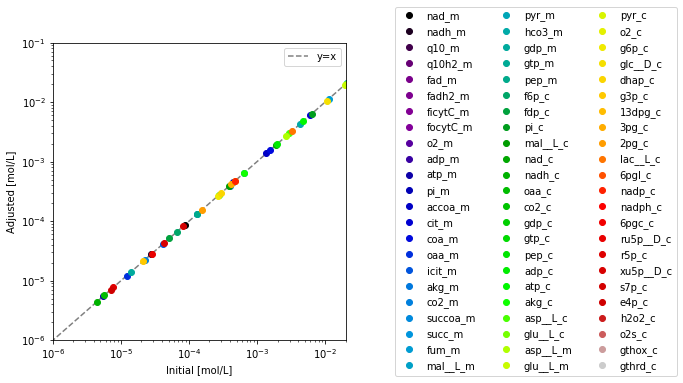

In [80]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_info['conc'], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()


In [67]:
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

Name,Core_Model
Memory address,0x01f5b5068b20
Stoichiometric Matrix,74x69
Matrix Rank,60
Number of metabolites,74
Initial conditions defined,74/74
Number of reactions,69
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [68]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
                or r== liver.reactions.PYRt2m
                or r== liver.reactions.PEPtm
                or r== liver.reactions.Htmi
                or r== liver.reactions.MALtm
                or r== liver.reactions.ATPtm
                or r== liver.reactions.AKGMALtm
                or r== liver.reactions.O2tm
                or r== liver.reactions.H2Otm
                or r== liver.reactions.CO2tm
                or r== liver.reactions.PItm
                or r== liver.reactions.Htm
            
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_NADH2_u10mi: 3615716743701030.000000
kf_FADH2ETC: 316395341373865459712.000000
kf_CYOR_u10mi: 4235840591458066739803159789568.000000
kf_CYOOm2i: 34918602412159629411435234622013735698432.000000
kf_ATPS4mi: 6596.330967
kf_Htmi: 1000000.000000
kf_CSm: 119950123.806946
kf_ACONTm: 362.546249
kf_ICDHxm: 547364748.395195
kf_AKGDm: 37707500486.626572
kf_SUCOASm: 3700461.248863
kf_SUCD1m: 0.000008
kf_FUMm: 279.947276
kf_MDHm: 3457769.864118
kf_PDHm: 714021133.495492
kf_PCm: 27648003399.384178
kf_PEPCKm: 11022775151858366.000000
kf_FBP: 406503.653670
kf_MALtm: 1000000.000000
kf_MDH: 1556263.333575
kf_PEPCK_re: 100000.000000
kf_HCO3Em: 598676.536554
kf_ATPtm: 1000000.000000
kf_AKGMALtm: 1000000.000000
kf_ASPTA: 1290876.247652
kf_ASPTAm: 1098578.414369
kf_PYRt2m: 1000000.000000
kf_ASPGLUm: 58063.573568
kf_O2tm: 1000000.000000
kf_H2Otm: 1000000.000000
kf_CO2tm: 1000000.000000
kf_NDPK1m: 176680087675.732391
kf_NDPK1: 100000.000000
kf_ATPM: 100000.000

In [81]:
# conc_solution.concentrations.co2_c
conc_solution.concentrations.o2_c

1.0

In [82]:
liver.boundary_conditions['h2o_b']=1 ##M # from HEPATOKIN conc
liver.boundary_conditions['h_b']=0.0064 ##M # from HEPATOKIN conc
liver.boundary_conditions['co2_b']=9.999999999999996e-11# from conc_solver
liver.boundary_conditions['o2s_b']=9.999999999999996e-11
liver.boundary_conditions['o2_b']=1.0 # from conc_solver


In [83]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [84]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [85]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Core_Model                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ---------------------                        │
│ NADPHM: {charge: 2.0}                        │
│ ============================================ │
╘══════════════════════════════════════════════╛


In [86]:
from roadrunner import __version__
__version__

'2.1.3'

In [88]:
from mass.util.matrix import eig
from mass.util.matrix import jacobian

In [94]:
jac= jacobian(liver)

# jac

AttributeError: 'builtin_function_or_method' object has no attribute 'rates'

In [92]:
eigen= eig(jac)
eigen

ValueError: object arrays are not supported

In [76]:
eig(liver.stoichiometric_matrix, right=True)

ValueError: expected square matrix

In [ ]:
liver.update_S(array_type="DataFrame", dtype=int)

In [ ]:
simG=Simulation(liver, verbose=True)
# simG.integrator.minimum_time_step=1e-15
simG.integrator.maximum_time_step=1e1
simG.integrator.maximum_num_steps=1e3
simG.integrator.initial_time_step=1e-12

# conc_sol, flux_sol = simG.find_steady_state(liver, strategy="simulate")
# for metabolite, solution in conc_sol.items():
#     print("{0}: {1}".format(metabolite, solution))


conc_sol, flux_sol = simG.find_steady_state(liver, strategy="nleq2")
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

In [ ]:
print(simG.integrator)

In [ ]:
# Setup simulation object


# simG.integrator.maximum_time_step= 1000
# Simulate from 0 to 1000 with 10001 points in the output
# simG.time_step
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e3),interpolate=True)
# Quickly render and display time profiles
# conc_sol.view_time_profile()